# Introduction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
import os
from tqdm import tqdm 
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
dataset = pd.read_csv("data.csv")
dataset.head()

,pixel_0000,pixel_0001,pixel_0002,pixel_0003,pixel_0004,pixel_0005,pixel_0006,pixel_0007,pixel_0008,pixel_0009,...,pixel_1015,pixel_1016,pixel_1017,pixel_1018,pixel_1019,pixel_1020,pixel_1021,pixel_1022,pixel_1023,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,character_01_ka


In [3]:
dataset.shape

(92000, 1025)

## A few points:

#### 1. Firstly the dataset originally has images stored in a flattened manner. Two dimensional array has been flattened into a one dimension array.

#### 2. I have come across notebooks that take the given 1-D array as input to build models. I appreciate the approach but believe that atleast some crucial information about the spacial arrangement of pixels is lost in doing so. Hence my modelling is based on 2-D image input.

#### 3. Though I have used the given csv from the dataset, I have added a portion briefly on how to read images from specific folders where the folder name is the class name. I hope this will act as a baseline for many others who are required to take input in this manner for other competitions and datasets as well.

# Reading Images from Folder with class name

In [4]:
def read_data():

    data_set_full = [] 
    for folder_path in glob.glob('/kaggle/input/devanagari-character-set/Images/Images/*'):

        class_name = folder_path.split('/')[-1]
        print(class_name)

        for img in tqdm(os.listdir(folder_path)): 
            path = os.path.join(folder_path, img)
            img = cv2.imread(path)
            data_set_full.append([np.array(img), class_name])
            #print(data_set_full)
            #break
        
    return data_set_full

# Class Distribution

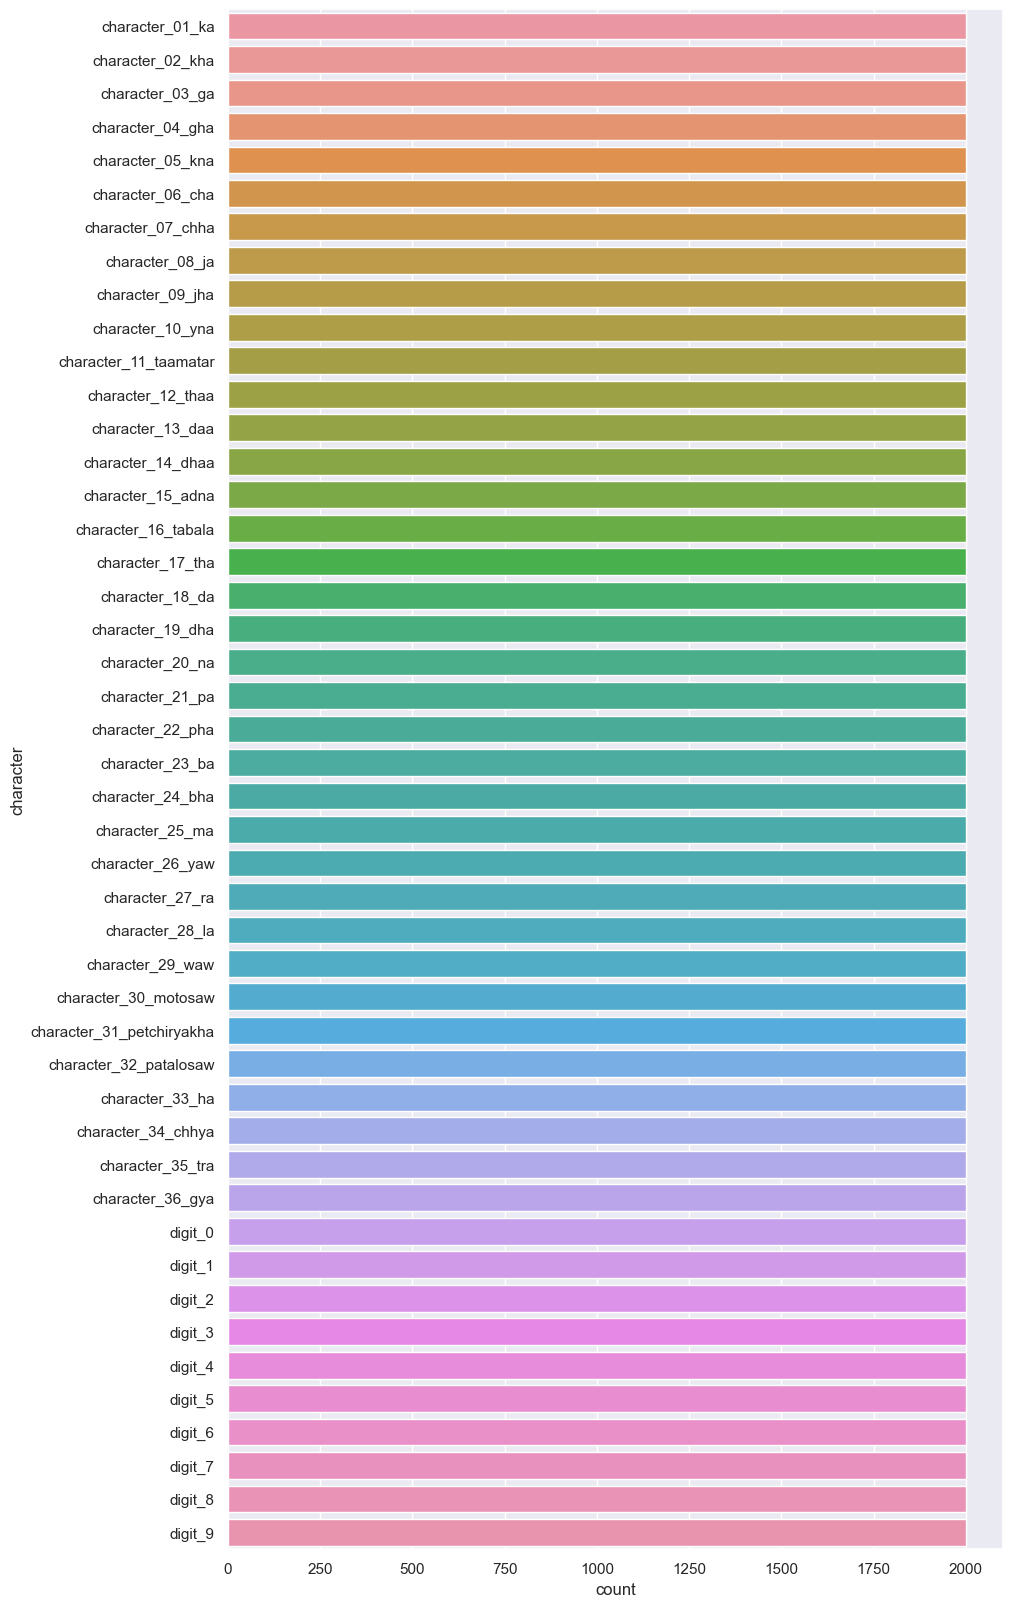

In [5]:
plt.figure(figsize = (10,20))
_ = sns.countplot(x=None, y=dataset.character)

In [6]:
dataset.drop(['character'], axis =1).iloc[0].max()

255

# Image Characteristics

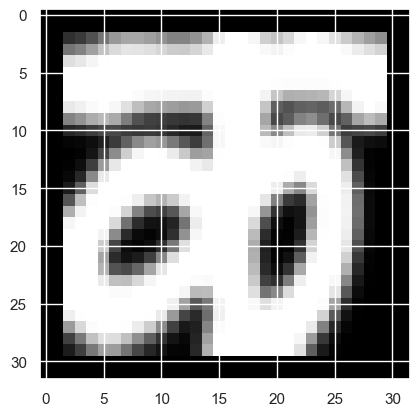

In [7]:
#Reading Images

img = (dataset.drop(['character'],axis=1).iloc[0]).to_numpy().reshape(32,32)
_ = plt.imshow(img, cmap = 'gray')

In [8]:
# This is a grayscale image and I have used cmap = 'gray' to for best suiting representation of the image. 
# Also notice the shades of gray in the image. 
# Had it been a binary image there would be just black and white colors. 
# But how did I identify its type?

# Identifying Grayscale Images

### Before going to the theory let's look at a plain old pythonic way of checking whether an image is grayscale

In [9]:
#import Image

def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w,h = img.size
    for i in range(w):
        for j in range(h):
            r,g,b = img.getpixel((i,j))
            if r != g != b: return False
    return True


### Basically, check every pixel to see if it is grayscale (R == G == B)

### Theory
A grayscale image is formed when the red, blue and green component of the image have the same value for each pixel. So that means we should have a multidimensional array with values like m x n x 3, 3 for representing the 3 channels. But here we can see from the dataset that each row represents a single image and has only one channel. Also the pixels have values other than 0 and 1 so its not binary. So does that mean that this image format is unknown to us and we can't identify it?

No, the image format is very well known to us by now and its none other than grayscale. Since the red, blue and green channels of all grayscale images have the same value at each pixel, it is smart to store the image in a single 2-D array rather than having 3 2-D arrays having the same values. Though when the image is read, the final result is a merge of the 3 channels (having same values of pixels) basically a grayscale image.


### Practical Example

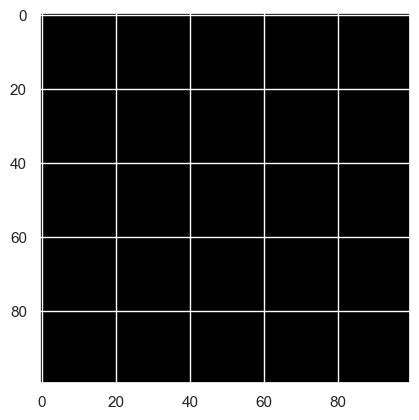

In [10]:
ones_array = np.ones([100, 100, 3], dtype=np.uint8)
_ = plt.imshow(ones_array)

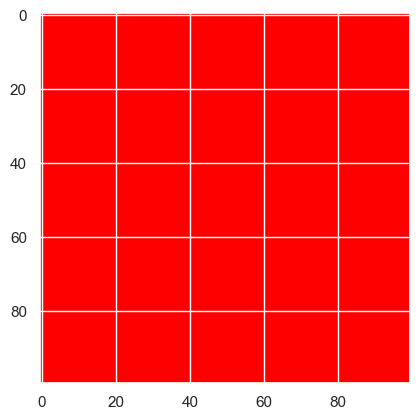

In [11]:
red_array = copy.deepcopy(ones_array)
red_array[:,:,0] = 255
red_array[:,:,1] = 0
red_array[:,:,2] = 0

_ = plt.imshow(red_array)

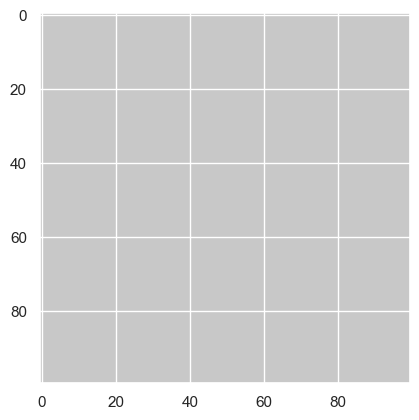

In [12]:
# Now to make any shade of gray

any_gray_array = copy.deepcopy(ones_array)
any_gray_array[:,:,0] = 200
any_gray_array[:,:,1] = 200
any_gray_array[:,:,2] = 200

_ = plt.imshow(any_gray_array)

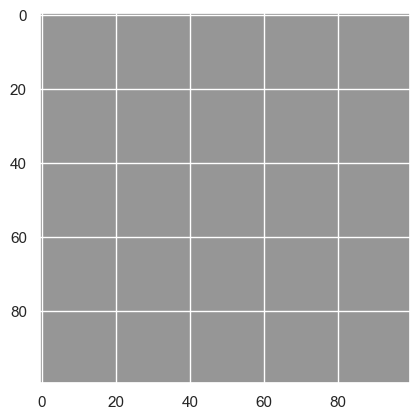

In [13]:
any_gray_array = copy.deepcopy(ones_array)
any_gray_array[:,:,0] = 150
any_gray_array[:,:,1] = 150
any_gray_array[:,:,2] = 150

_ = plt.imshow(any_gray_array)

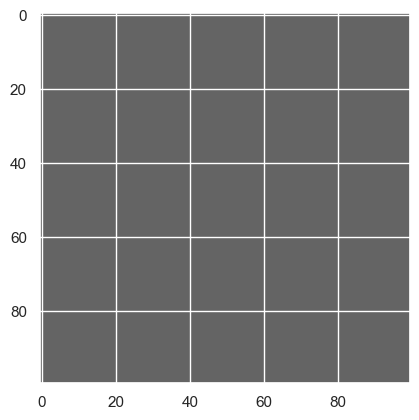

In [14]:
any_gray_array = copy.deepcopy(ones_array)
any_gray_array[:,:,0] = 100
any_gray_array[:,:,1] = 100
any_gray_array[:,:,2] = 100

_ = plt.imshow(any_gray_array)

In [15]:
# Now let's come back to the modelling pipeline

# Splitting Input and Target Data

In [16]:
x = dataset.drop(['character'],axis = 1)
y_text = dataset.character

In [17]:
x.shape

(92000, 1024)

### Target Label Binarization

In [18]:
from sklearn.preprocessing import LabelBinarizer
binencoder = LabelBinarizer()
y = binencoder.fit_transform(y_text)

In [19]:
y[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

### Input Image Reshaping

In [20]:
x = x.values.reshape(x.shape[0],32,32,1)
x.shape

(92000, 32, 32, 1)

# Image Normalisation

In [21]:
#Normalization is a process that changes the range of pixel intensity values
print(x.max())
print(x.mean())
print(x.sum())

255
61.25059867527174
5770296400


In [22]:
x = x/255.0
print(x.max())
print(x.mean())
print(x.sum())

1.0
0.2401984261775361
22628613.33333332


In [23]:
#Splitting into Training and Testing set
print(x.shape)
print(y.shape)

(92000, 32, 32, 1)
(92000, 46)


In [24]:
(unique, counts) = np.unique(y, return_counts=True, axis = 0)
frequencies = np.asarray((binencoder.inverse_transform(unique), counts)).T

In [25]:
frequencies

array([['digit_9', '2000'],
       ['digit_8', '2000'],
       ['digit_7', '2000'],
       ['digit_6', '2000'],
       ['digit_5', '2000'],
       ['digit_4', '2000'],
       ['digit_3', '2000'],
       ['digit_2', '2000'],
       ['digit_1', '2000'],
       ['digit_0', '2000'],
       ['character_36_gya', '2000'],
       ['character_35_tra', '2000'],
       ['character_34_chhya', '2000'],
       ['character_33_ha', '2000'],
       ['character_32_patalosaw', '2000'],
       ['character_31_petchiryakha', '2000'],
       ['character_30_motosaw', '2000'],
       ['character_29_waw', '2000'],
       ['character_28_la', '2000'],
       ['character_27_ra', '2000'],
       ['character_26_yaw', '2000'],
       ['character_25_ma', '2000'],
       ['character_24_bha', '2000'],
       ['character_23_ba', '2000'],
       ['character_22_pha', '2000'],
       ['character_21_pa', '2000'],
       ['character_20_na', '2000'],
       ['character_19_dha', '2000'],
       ['character_18_da', '2000'],
    

In [26]:
#Stratified split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state=42, stratify = y)
#Shape check
x_train.shape

(61640, 32, 32, 1)

In [27]:
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(30360, 32, 32, 1)
(61640, 46)
(30360, 46)


In [28]:
#Frequency check
(unique, counts) = np.unique(y_train, return_counts=True, axis = 0)
frequencies = np.asarray((binencoder.inverse_transform(unique), counts)).T
frequencies

array([['digit_9', '1340'],
       ['digit_8', '1340'],
       ['digit_7', '1340'],
       ['digit_6', '1340'],
       ['digit_5', '1340'],
       ['digit_4', '1340'],
       ['digit_3', '1340'],
       ['digit_2', '1340'],
       ['digit_1', '1340'],
       ['digit_0', '1340'],
       ['character_36_gya', '1340'],
       ['character_35_tra', '1340'],
       ['character_34_chhya', '1340'],
       ['character_33_ha', '1340'],
       ['character_32_patalosaw', '1340'],
       ['character_31_petchiryakha', '1340'],
       ['character_30_motosaw', '1340'],
       ['character_29_waw', '1340'],
       ['character_28_la', '1340'],
       ['character_27_ra', '1340'],
       ['character_26_yaw', '1340'],
       ['character_25_ma', '1340'],
       ['character_24_bha', '1340'],
       ['character_23_ba', '1340'],
       ['character_22_pha', '1340'],
       ['character_21_pa', '1340'],
       ['character_20_na', '1340'],
       ['character_19_dha', '1340'],
       ['character_18_da', '1340'],
    

In [29]:
(unique, counts) = np.unique(y_test, return_counts=True, axis = 0)
frequencies = np.asarray((binencoder.inverse_transform(unique), counts)).T
frequencies

array([['digit_9', '660'],
       ['digit_8', '660'],
       ['digit_7', '660'],
       ['digit_6', '660'],
       ['digit_5', '660'],
       ['digit_4', '660'],
       ['digit_3', '660'],
       ['digit_2', '660'],
       ['digit_1', '660'],
       ['digit_0', '660'],
       ['character_36_gya', '660'],
       ['character_35_tra', '660'],
       ['character_34_chhya', '660'],
       ['character_33_ha', '660'],
       ['character_32_patalosaw', '660'],
       ['character_31_petchiryakha', '660'],
       ['character_30_motosaw', '660'],
       ['character_29_waw', '660'],
       ['character_28_la', '660'],
       ['character_27_ra', '660'],
       ['character_26_yaw', '660'],
       ['character_25_ma', '660'],
       ['character_24_bha', '660'],
       ['character_23_ba', '660'],
       ['character_22_pha', '660'],
       ['character_21_pa', '660'],
       ['character_20_na', '660'],
       ['character_19_dha', '660'],
       ['character_18_da', '660'],
       ['character_17_tha', '660'

In [30]:
#So the train data has 1340 examples and test has 660 examples of each of the 46 classes.

# Modelling

In [31]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [32]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(46, activation = "softmax"))

In [33]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

E:\Anaconda\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Non-trainable params: 0
_________________________________________________________________


In [34]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
epochs = 7
batch_size = 86

In [35]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, 
       validation_data = (x_test, y_test), verbose = 2)

Epoch 1/7
717/717 - 423s - loss: 0.9350 - accuracy: 0.7383 - val_loss: 0.1696 - val_accuracy: 0.9490 - 423s/epoch - 591ms/step
Epoch 2/7
717/717 - 363s - loss: 0.2447 - accuracy: 0.9253 - val_loss: 0.0935 - val_accuracy: 0.9717 - 363s/epoch - 506ms/step
Epoch 3/7
717/717 - 354s - loss: 0.1634 - accuracy: 0.9519 - val_loss: 0.0675 - val_accuracy: 0.9802 - 354s/epoch - 494ms/step
Epoch 4/7
717/717 - 363s - loss: 0.1273 - accuracy: 0.9620 - val_loss: 0.0636 - val_accuracy: 0.9814 - 363s/epoch - 506ms/step
Epoch 5/7
717/717 - 383s - loss: 0.1134 - accuracy: 0.9666 - val_loss: 0.0526 - val_accuracy: 0.9851 - 383s/epoch - 534ms/step
Epoch 6/7
717/717 - 388s - loss: 0.1020 - accuracy: 0.9706 - val_loss: 0.0568 - val_accuracy: 0.9840 - 388s/epoch - 541ms/step
Epoch 7/7
717/717 - 378s - loss: 0.0992 - accuracy: 0.9722 - val_loss: 0.0661 - val_accuracy: 0.9832 - 378s/epoch - 527ms/step


# Evaluation

In [36]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.32%


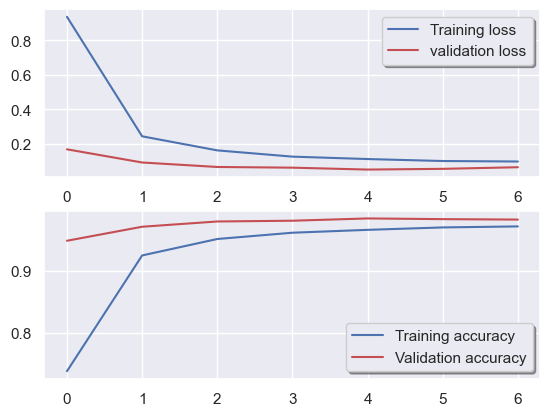

In [37]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)